# Object Detection and Recognition
# R&D Project

In [47]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
import argparse
import os
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
import PIL
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

In [48]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    
    box_scores = box_confidence*box_class_probs
    box_classes = K.argmax(box_scores,-1)
    box_class_scores = K.max(box_scores,-1)
    filtering_mask = box_class_scores>threshold
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    return scores, boxes, classes

In [49]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    #print("scores[2] = " + str(scores[2].eval()))
    #print("boxes[2] = " + str(boxes[2].eval()))
    #print("classes[2] = " + str(classes[2].eval()))
    #print("scores.shape = " + str(scores.shape))
    #print("boxes.shape = " + str(boxes.shape))
    #print("classes.shape = " + str(classes.shape))

In [50]:
def iou(box1, box2):

    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    inter_area = (yi2-yi1)*(xi2-xi1)
    box1_area = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area+box2_area-inter_area
    iou = inter_area/union_area
    
    return iou

In [51]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
#print("iou = " + str(iou(box1, box2)))

In [52]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')   
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold)
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)
    
    return scores, boxes, classes

In [53]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    #print("scores[2] = " + str(scores[2].eval()))
    #print("boxes[2] = " + str(boxes[2].eval()))
    #print("classes[2] = " + str(classes[2].eval()))
    #print("scores.shape = " + str(scores.eval().shape))
    #print("boxes.shape = " + str(boxes.eval().shape))
    #print("classes.shape = " + str(classes.eval().shape))

In [54]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
   
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

In [55]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    #print("scores[2] = " + str(scores[2].eval()))
    #print("boxes[2] = " + str(boxes[2].eval()))
    #print("classes[2] = " + str(classes[2].eval()))
    #print("scores.shape = " + str(scores.eval().shape))
    #print("boxes.shape = " + str(boxes.eval().shape))
    #print("classes.shape = " + str(classes.eval().shape))

In [56]:
sess = K.get_session()

In [57]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

In [58]:
yolo_model = load_model("model_data/yolo.h5")

c:\users\john\appdata\local\programs\python\python36\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [73]:
#yolo_model.summary()

In [60]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [61]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [62]:
def predict(sess, image_file):
    
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],feed_dict={yolo_model.input:image_data,K.learning_phase(): 0})
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    image.save(os.path.join("out", image_file), quality=90)
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 6 boxes for test12.jpg
chair 0.61 (834, 215) (978, 411)
cell phone 0.62 (562, 398) (689, 612)
person 0.69 (509, 97) (1025, 707)
bottle 0.70 (997, 370) (1107, 644)
chair 0.73 (238, 177) (350, 294)
person 0.74 (316, 60) (452, 262)


c:\users\john\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


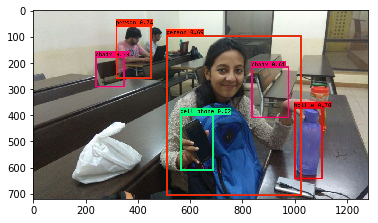

In [71]:
out_scores, out_boxes, out_classes = predict(sess, "test12.jpg")